### Analysis of the spacing between filaments in Didium cells

In [9]:
# Taking input from the user
file_name = input("Please enter a file file_name: ")

In [10]:
generate_pc = False

In [16]:
import os
from didinium_pc import DidiniumPC

if file_name.lower().endswith(".czi") or file_name.lower().endswith(".txt"):
    file_name = file_name[:-4]

point_cloud_files_exist = False

current_dir = os.getcwd()

files = [os.path.join(current_dir, "output_data",  fl) for fl in [file_name+".txt", file_name+"_channel_one.txt", file_name+"_channel_three.txt"] ]

if all(os.path.exists(file) for file in files):
    point_cloud_files_exist = True

if generate_pc or not point_cloud_files_exist:
    dpc = DidiniumPC(file_name=os.path.join(current_dir, "raw_data",  file_name + '.czi'))
else:
    dpc = DidiniumPC(file_name=os.path.join(current_dir, "output_data",  file_name + '.txt'))

c:\Users\ozberk\Downloads\lpl_image_analysis\2_3D_Cell_Analysis\output_data\didinium_1
Point clouds are loaded.


In [17]:
dpc.align_axial_plane_to_z(visualize=False)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

aligned_pts = np.asarray(dpc.pc_channel_one_alligned.points)


In [23]:
x1 = aligned_pts[:,0] 
y1 = aligned_pts[:,1] 
z1 = aligned_pts[:,2] 

In [25]:
unique_z = np.unique(z1)

In [32]:
len(unique_z)

765583

In [116]:
(650000 - 625000)/5

5000.0

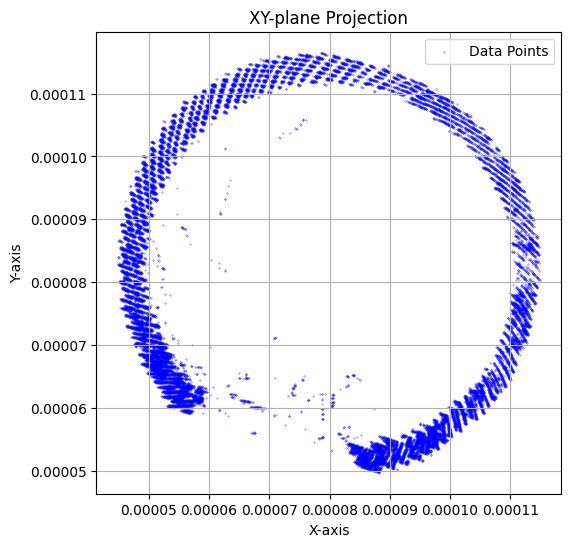

In [185]:
unique_z = np.unique(z1)
# Filter the data points based on the threshold_z
n = 636000
filtered_indices = np.where((z1 > unique_z[n]) & (z1 < unique_z[n+25000]))
filtered_x = x1[filtered_indices]
filtered_y = y1[filtered_indices]
filtered_z = z1[filtered_indices]

# Projections on xy-plane
plt.figure(figsize=(6, 6))
plt.scatter(filtered_x, filtered_y, c='b', marker='o', s=0.05, label='Data Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('XY-plane Projection')
plt.grid(True)
plt.legend()
plt.show()

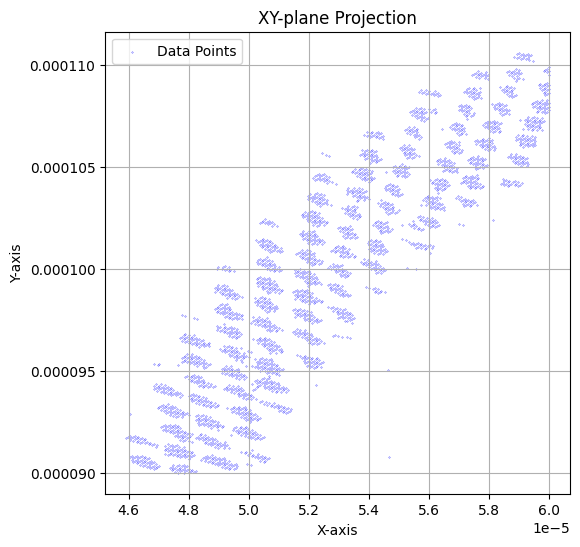

In [186]:
# Filter the data points based on x
filtered_indices = np.where((filtered_x < 0.00006) & (filtered_y > 0.00009))
filtered_x = filtered_x[filtered_indices]
filtered_y = filtered_y[filtered_indices]
filtered_z = filtered_z[filtered_indices]


# Projections on xy-plane
plt.figure(figsize=(6, 6))
plt.scatter(filtered_x, filtered_y, c='b', marker='o', s=0.05, label='Data Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('XY-plane Projection')
plt.grid(True)
plt.legend()
plt.show()

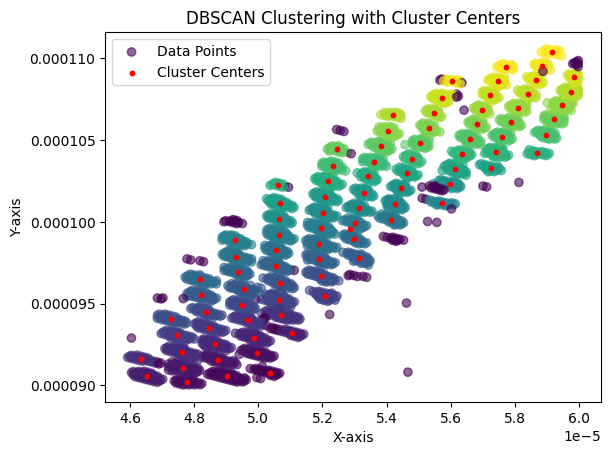

In [189]:
from sklearn.cluster import DBSCAN

data = np.stack([filtered_x, filtered_y], axis=-1)

# Create the DBSCAN model
dbscan = DBSCAN(eps=2.5e-7, min_samples=10)

# Fit the model to the data and get the cluster labels
cluster_labels = dbscan.fit_predict(data)

# Get the cluster centers (there are no explicit cluster centers in DBSCAN, so we'll calculate them manually)
unique_labels = np.unique(cluster_labels)
cluster_centers = np.array([data[cluster_labels == label].mean(axis=0) for label in unique_labels])

# Create a scatter plot for the data points
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, label='Data Points')

# Create a scatter plot for the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='o', s=10, label='Cluster Centers')

# Set plot labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('DBSCAN Clustering with Cluster Centers')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [192]:
from scipy.optimize import least_squares

def circle_residuals(params, x, y):
    cx, cy, r = params
    return np.abs(np.sqrt((x - cx)**2 + (y - cy)**2) - r)

def fit_circle_to_points(x_data, y_data):
    # Initial guess for the circle parameters (center and radius)
    initial_guess = [np.mean(x_data), np.mean(y_data), np.mean(np.sqrt((x_data - np.mean(x_data))**2 + (y_data - np.mean(y_data))**2))]

    # Fit the circle parameters using least squares
    result = least_squares(circle_residuals, initial_guess, args=(x_data, y_data))

    # Extract the center and radius of the fitted circle
    cx, cy, r = result.x
    return cx, cy, r

# Example usage:
# Assuming x_points and y_points are your 2D point cloud data
x_points = cluster_centers[:,0]
y_points = cluster_centers[:,1]

cx, cy, r = fit_circle_to_points(x_points, y_points)
print("Center (x, y):", cx, cy)
print("Radius:", r)

Center (x, y): 8.957240191419526e-05 7.710479793840486e-05
Radius: 4.384337715155781e-05


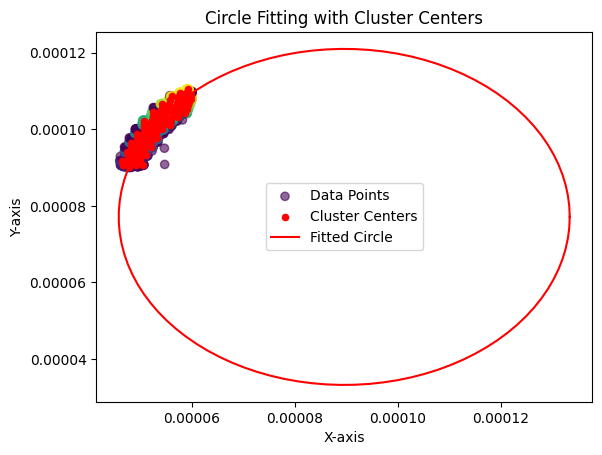

In [193]:
# Create a scatter plot for the data points
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, label='Data Points')

# Create a scatter plot for the cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='o', s=20, label='Cluster Centers')

# Plot the fitted circle
theta = np.linspace(0, 2*np.pi, 100)
x_circle = cx + r * np.cos(theta)
y_circle = cy + r * np.sin(theta)
plt.plot(x_circle, y_circle, 'r', label='Fitted Circle')

# Set plot labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Circle Fitting with Cluster Centers')

# Add a legend
plt.legend()

# Show the plot
plt.show()